In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from utils.data_processing import *
from utils.visualization import *
from kb.weidmann_fd import *

# Import Data

In [3]:
# Load datasets
# (Ped_id, Frame, X, Y, Mean_Spacing, Speed, Density)
bottleneck_clean_files = [x for x in Path("Bottleneck_Clean").iterdir()]
corridor_clean_files = [x for x in Path("Corridor_Clean").iterdir()]
dict_bottleneck = load_directory(bottleneck_clean_files)
dict_corridor = load_directory(corridor_clean_files)

# Estimating v0 directly from data

In [4]:
# Preliminary analysis on relation between mean spacing s_K and density D
# s_K = 0.0 if there is only 1 pedestrian in the frame
# d <= 1.1/(measurement area) when pedestrian density only has 1 person (1.1 due to floating point)

sum = 0
print('Bottleneck: s_K | D')
for key in dict_bottleneck.keys():
    print(key, end=': ')
    sum += np.shape(dict_bottleneck[key][np.where(dict_bottleneck[key][:,4] == 0.0)])[0]
    print(np.shape(dict_bottleneck[key][np.where(dict_bottleneck[key][:,4] == 0.0)])[0], end=' | ')
    print(np.shape(dict_bottleneck[key][np.where(dict_bottleneck[key][:,6] <= 1.1/(8.0*1.8))])[0])
print('Total:', sum)

sum = 0
print('Corridor: s_K | D')
for key in dict_corridor.keys():
    print(key, end=': ')
    sum += np.shape(dict_corridor[key][np.where(dict_corridor[key][:,4] == 0.0)])[0]
    print(np.shape(dict_corridor[key][np.where(dict_corridor[key][:,4] == 0.0)])[0], end=' | ')
    print(np.shape(dict_corridor[key][np.where(dict_corridor[key][:,6] <= 1.1/(6.0*1.8))])[0])
print('Total:', sum)
    

Bottleneck: s_K | D
uo-180-070-clean: 18 | 18
uo-180-095-clean: 12 | 12
uo-180-120-clean: 13 | 13
uo-180-180-clean: 11 | 11
Total: 54
Corridor: s_K | D
ug-180-015-clean: 260 | 260
ug-180-030-clean: 23 | 23
ug-180-060-clean: 3 | 3
ug-180-085-clean: 15 | 15
ug-180-095-clean: 10 | 10
ug-180-110-clean: 3 | 3
ug-180-140-clean: 4 | 4
ug-180-230-clean: 4 | 4
Total: 322


In [5]:
# Estimating v_0 from data
mean_v0 = np.array([])
for key in dict_bottleneck.keys():
    m = dict_bottleneck[key][np.where(dict_bottleneck[key][:,6] <= 1.1/(8.0*1.8))][:, 5]
    print(key, ' : ', np.mean(m))
    mean_v0 = np.concatenate((mean_v0, m))
print('Bottleneck mean v0', ' : ', np.mean(mean_v0))

for key in dict_corridor.keys():
    m = dict_corridor[key][np.where(dict_corridor[key][:,6] <= 1.1/(6.0*1.8))][:, 5]
    print(key, ' : ', np.mean(m))
    mean_v0 = np.concatenate((mean_v0, m))
print('Corridor mean v0', ' : ', np.mean(mean_v0))

uo-180-070-clean  :  0.7397777777777778
uo-180-095-clean  :  0.3239166666666667
uo-180-120-clean  :  1.6551538461538462
uo-180-180-clean  :  1.432
Bottleneck mean v0  :  1.0087407407407407
ug-180-015-clean  :  0.7335961538461537
ug-180-030-clean  :  1.0019130434782606
ug-180-060-clean  :  0.7840000000000001
ug-180-085-clean  :  0.5351333333333331
ug-180-095-clean  :  0.7335
ug-180-110-clean  :  0.622
ug-180-140-clean  :  1.2634999999999998
ug-180-230-clean  :  0.715
Corridor mean v0  :  0.7865558510638297


# Estimating from curve fitting (scipy.optimize.curve_fitting)

In [6]:
# Import
from scipy.optimize import curve_fit

# Concatenate all data
# (Ped_id, Frame, X, Y, Mean_Spacing, Speed, Density)
all_bottleneck = np.empty((0,7))
for key in dict_bottleneck.keys():
    all_bottleneck = np.concatenate((all_bottleneck, dict_bottleneck[key]))
all_corridor = np.empty((0,7))
for key in dict_corridor.keys():
    all_corridor = np.concatenate((all_corridor, dict_corridor[key]))
    
# Extract (Mean_Spacing, Speed, Density)
all_bottleneck = all_bottleneck[:, 4:7]
all_corridor = all_corridor[:, 4:7]

In [7]:
# Datasets for estimating v0 by curve fitting original Weidmann function
# Set T, l according to paper
# Bottleneck: v0, T, l = 1.64, 0.49, 0.61
# Corridor: T, l = 1.5, 0.85, 0.64

# Density are x-values
x_bottleneck_ds = all_bottleneck[:,2]
x_corridor_ds = all_corridor[:,2]
y_bottleneck_ds = all_bottleneck[:,1]
y_corridor_ds = all_corridor[:,1]

In [8]:
# Datasets for estimating v0, T, l using curve fitting on W()
# Set T, l according to paper
# Bottleneck: v0, T, l = 1.64, 0.49, 0.61
# Corridor: T, l = 1.5, 0.85, 0.64

# Mean Spacing are x-values
x_bottleneck_ms = all_bottleneck[:,0]
x_corridor_ms = all_corridor[:,0]
y_bottleneck_ms = all_bottleneck[:,1]
y_corridor_ms = all_corridor[:,1]

### Curve fitting on original Weidmann model via density

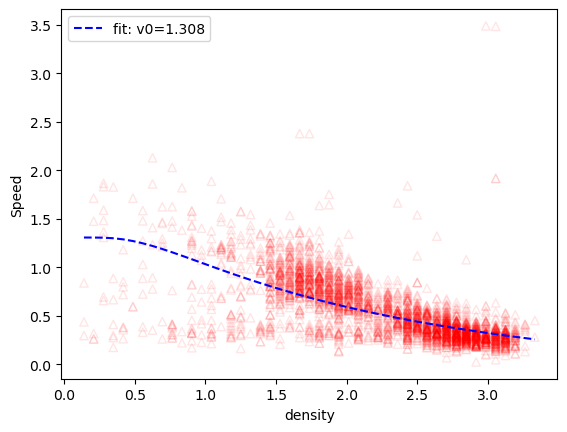

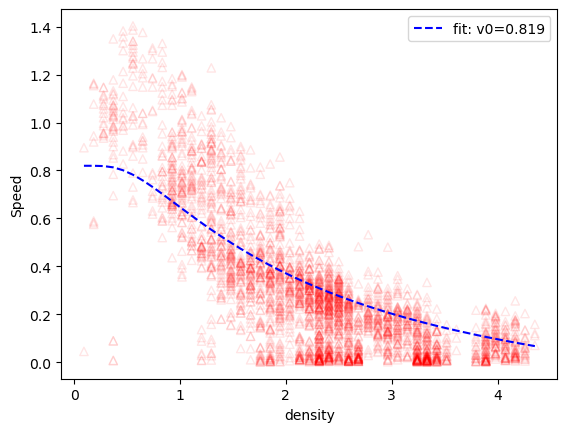

MSE:  (0.06715030041422182, 0.27678770556947363)
MSE:  (0.03429870941727667, 0.059550298574451065)


In [9]:
# Estimate v0
opt_bottleneck_ds = curve_fit(weidmann, x_bottleneck_ds, y_bottleneck_ds, np.array([1.3]))
opt_corridor_ds = curve_fit(weidmann, x_corridor_ds, y_corridor_ds, np.array([1.3]))
visualize_weidmann(weidmann, x_bottleneck_ds, y_bottleneck_ds, opt_bottleneck_ds, 'density')
visualize_weidmann(weidmann, x_corridor_ds, y_corridor_ds, opt_corridor_ds, 'density')

# Calculate the mean squared error
print('MSE: ', mse(weidmann, x_bottleneck_ds, y_bottleneck_ds, opt_bottleneck_ds))
print('MSE: ', mse(weidmann, x_corridor_ds, y_corridor_ds, opt_corridor_ds))

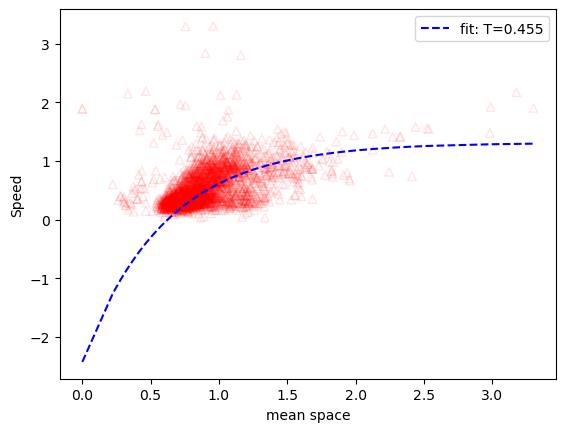

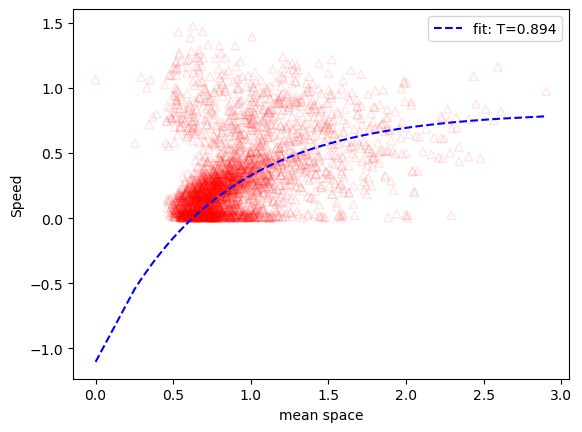

MSE:  (0.11723068557682181, 0.4577991563683897)
MSE:  (0.10359049742043111, 0.27841084272143357)


In [10]:
# Estimate T, l from previous v0
opt_bottleneck_ms = curve_fit(w_bottleneck_v0, x_bottleneck_ms, y_bottleneck_ms, np.array([0.49]))
opt_corridor_ms = curve_fit(w_corridor_v0, x_corridor_ms, y_corridor_ms, np.array([0.85]))
visualize_weidmann(w_bottleneck_v0, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms, 'mean space', weid=True)
visualize_weidmann(w_corridor_v0, x_corridor_ms, y_corridor_ms, opt_corridor_ms, 'mean space', weid=True)

# Calculate the mean squared error
print('MSE: ', mse(w_bottleneck_v0, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms))
print('MSE: ', mse(w_corridor_v0, x_corridor_ms, y_corridor_ms, opt_corridor_ms))

### Curve fitting on Weidmann model from paper

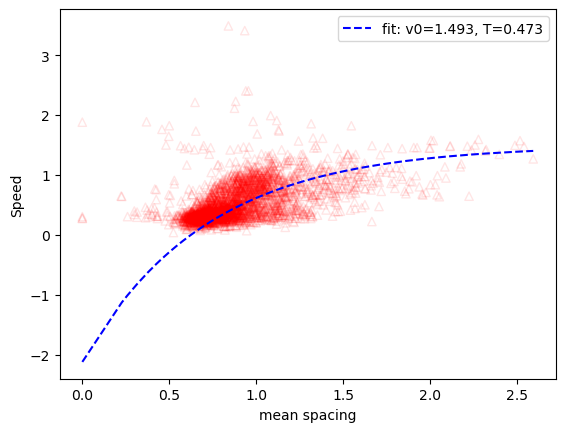

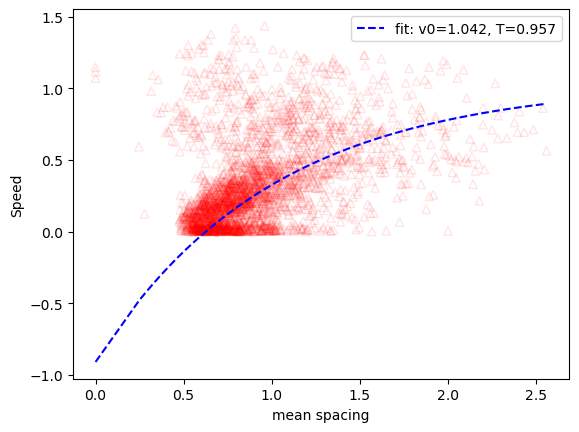

MSE:  (0.11657338726520998, 0.429696914479868)
MSE:  (0.10294311985573013, 0.26815401265958816)


In [11]:
# Estimate v0, T, l
opt_bottleneck_ms = curve_fit(w_wrap, x_bottleneck_ms, y_bottleneck_ms, np.array([1.64, 0.49]))
opt_corridor_ms = curve_fit(w_wrap, x_corridor_ms, y_corridor_ms, np.array([1.5, 0.85]))
visualize_weidmann(w_wrap, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms, 'mean spacing')
visualize_weidmann(w_wrap, x_corridor_ms, y_corridor_ms, opt_corridor_ms, 'mean spacing')

# Calculate the mean squared error
print('MSE: ', mse(w_wrap, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms))
print('MSE: ', mse(w_wrap, x_corridor_ms, y_corridor_ms, opt_corridor_ms))

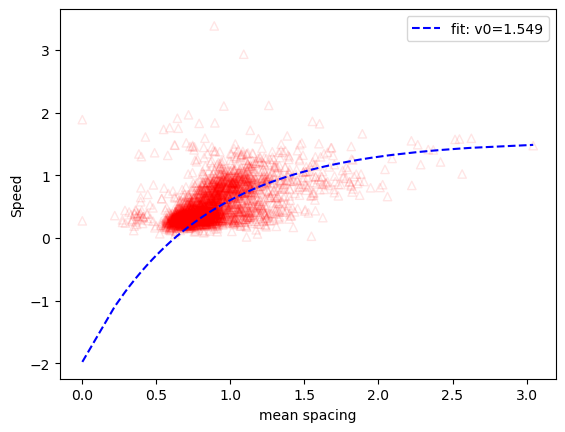

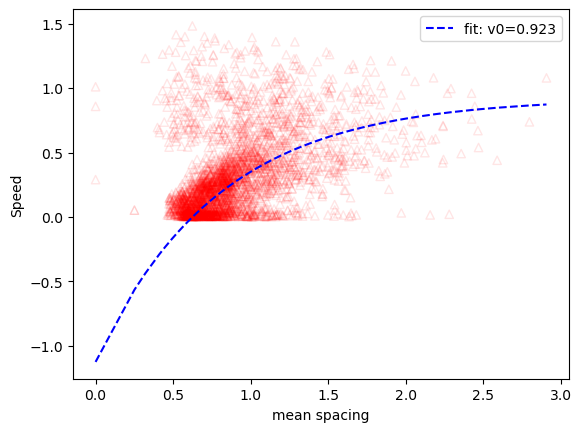

MSE:  (0.116692347768372, 0.4185829604267428)
MSE:  (0.10341730654268574, 0.27921447172558594)


In [12]:
# Estimate v0 with T, l as given in paper
opt_bottleneck_ms = curve_fit(w_bottleneck, x_bottleneck_ms, y_bottleneck_ms, np.array([1.6]))
opt_corridor_ms = curve_fit(w_corridor, x_corridor_ms, y_corridor_ms, np.array([1.6]))
visualize_weidmann(w_bottleneck, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms, 'mean spacing')
visualize_weidmann(w_corridor, x_corridor_ms, y_corridor_ms, opt_corridor_ms, 'mean spacing')

# Calculate the mean squared error
print('MSE: ', mse(w_bottleneck, x_bottleneck_ms, y_bottleneck_ms, opt_bottleneck_ms))
print('MSE: ', mse(w_corridor, x_corridor_ms, y_corridor_ms, opt_corridor_ms))